In [149]:
import pandas as pd
import numpy as np
train_features = pd.read_csv("./q3/RNA-Seq dataset/train.csv")
train_labels = pd.read_csv("./q3/RNA-Seq dataset/train_labels.csv")
test_features = pd.read_csv("./q3/RNA-Seq dataset/test.csv")

train_features.drop("Unnamed: 0", axis=1, inplace=True)
train_labels.drop("Unnamed: 0", axis=1, inplace=True)
test_features_sample_names = test_features["Unnamed: 0"].copy()
test_features.drop("Unnamed: 0", axis=1, inplace=True)


In [150]:
# Display the shape of the data
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Features Shape:", test_features.shape)
print()

# Display the first few rows of the data
print("Train Features:")
print(train_features.head())
print()

print("Train Labels:")
print(train_labels.head())
print()

print("Test Features:")
print(test_features.head())
print()

# Check for missing values
print("Missing Values:")
print(train_features.isnull().sum())
print()

# Check the data types of features and labels
print("Data Types:")
print(train_features.dtypes)
print(train_labels.dtypes)
print()

# Statistical summary of features
print("Summary Statistics:")
print(train_features.describe())

Train Features Shape: (700, 20531)
Train Labels Shape: (700, 1)
Test Features Shape: (101, 20531)

Train Features:
   gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3     0.0  3.467853  3.581918  6.620243   9.706829     0.0  7.758510   
4     0.0  1.224966  1.691177  6.572007   9.640511     0.0  6.754888   

     gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0  0.591871     0.0     0.0  ...    4.926711    8.210257    9.723516   
1  0.000000     0.0     0.0  ...    4.593372    7.323865    9.740931   
2  0.452595     0.0     0.0  ...    5.125213    8.127123   10.908640   
3  0.000000     0.0     0.0  ...    5.726657    8.602588    9.928339   
4  0.531868     0.0     0.0  ...    5.105904    7.927968    9.673966   

   gene_20524  gene

BRCA    264
KIRC    130
LUAD    124
PRAD    112
COAD     70
Name: Class, dtype: int64


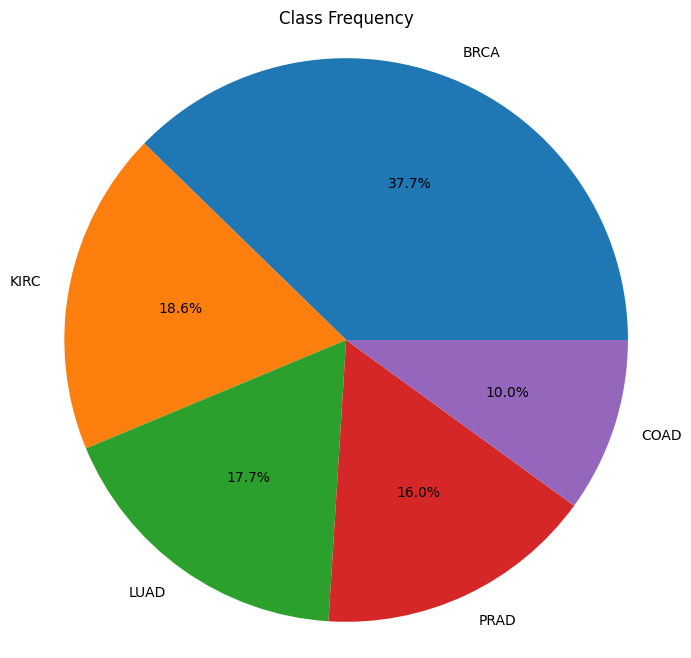

In [151]:
import matplotlib.pyplot as plt

# Get the frequency of each class
class_counts = train_labels['Class'].value_counts()

print(class_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Frequency')
plt.axis('equal')
plt.show()


In [152]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels["Class"])

labels = label_encoder.transform(train_labels["Class"])


In [153]:
import torch
import torch.nn.functional as tF

# Example usage
input_size = train_features.shape[1]  # Number of features in the system
num_classes = train_labels["Class"].nunique()  # Number of unique classes

# Convert train_features to torch tensor
train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)

# Convert test_features to torch tensor
test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)

# Convert labels to torch tensor (column vector)
labels_tensor = tF.one_hot(torch.tensor(labels, dtype=torch.int64), num_classes).squeeze().float()



In [154]:
train_features_tensor

tensor([[ 0.0000,  2.0172,  3.2655,  ...,  8.9213,  5.2868,  0.0000],
        [ 0.0000,  0.5927,  1.5884,  ...,  9.3979,  2.0942,  0.0000],
        [ 0.0000,  3.5118,  4.3272,  ..., 10.0905,  1.6830,  0.0000],
        ...,
        [ 0.0000,  3.2496,  3.7075,  ...,  9.4667,  4.6775,  0.5867],
        [ 0.0000,  2.5903,  2.7880,  ..., 10.4006,  5.7188,  0.0000],
        [ 0.0000,  2.3252,  3.8059,  ...,  9.8448,  4.5507,  0.0000]])

In [155]:
labels_tensor

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [156]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class MLP(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(50, 20)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(20, num_classes)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.gelu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)
    
    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.forward(features)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        print("loss: {}".format(loss))
        return loss





model = MLP(input_size, num_classes)




In [157]:
from torch.utils.data import  TensorDataset, DataLoader


train_dataset = TensorDataset(train_features_tensor, labels_tensor)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [158]:

trainer = pl.Trainer(max_epochs=1)

for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Data type: {param.dtype}")

print("Input Tensor Data Type:", train_features_tensor.dtype)


trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 1.0 M 
1 | gelu    | GELU    | 0     
2 | fc2     | Linear  | 1.0 K 
3 | sigmoid | Sigmoid | 0     
4 | fc3     | Linear  | 105   
5 | softmax | Softmax | 0     
------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.111     Total estimated model params size (MB)
/opt/anaconda3/envs/sut-default-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/en

Parameter name: fc1.weight, Data type: torch.float32
Parameter name: fc1.bias, Data type: torch.float32
Parameter name: fc2.weight, Data type: torch.float32
Parameter name: fc2.bias, Data type: torch.float32
Parameter name: fc3.weight, Data type: torch.float32
Parameter name: fc3.bias, Data type: torch.float32
Input Tensor Data Type: torch.float32
Epoch 0:  83%|████████▎ | 5/6 [00:00<00:00, 27.76it/s, v_num=13]

/var/folders/29/lt38nz310nn4dylkcy5l8k740000gn/T/ipykernel_66508/3162648837.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


loss: 1.5594044923782349
Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 30.03it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 27.39it/s, v_num=13]


In [159]:
def get_prediction(features):
    result = model.forward(features)
    predicted_labels_idx = torch.argmax(result, dim=1)
    predicted_labels = label_encoder.inverse_transform(predicted_labels_idx)
    print(predicted_labels_idx)
    print(predicted_labels)
    return predicted_labels

get_prediction(test_features_tensor)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
['BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA' 'BRCA'
 'BRCA' 'BRCA' 'B

/var/folders/29/lt38nz310nn4dylkcy5l8k740000gn/T/ipykernel_66508/3162648837.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


array(['BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA'], dtype=object)